Note : All work has been done using R language.

In [ ]:
library(data.table)
library(tidyverse)
library(fst)
library(microbenchmark)

## Reading & Compressing & Re-Reading Data

In [2]:
data_path <- 'data/'
serialized_data_path <- 'data_serialized/'

list.files(data_path)

[1] "economic_calendar.csv"      "economic_variables.csv"    
[3] "live_digital_campaigns.csv" "transactions.csv"

-----------------

I am going to read each file separately then compress (serialize) them all to read faster and use less space.

In [3]:
for(i in list.files(data_path)){
    object_name <- gsub('.csv','.obj',i)
    serialized_object_name <- gsub('.csv','.fst',i)
    eval(parse(text = sprintf("%s <- fread('%s%s')",object_name,data_path,i)))
    eval(parse(text = sprintf("write.fst(%s,'%s%s')",object_name,serialized_data_path,serialized_object_name)))
    eval(parse(text = sprintf('rm(%s); gc()',object_name)))
    IRdisplay::display(sprintf('%s Done.',gsub('.obj','',object_name)))
}

[1] "economic_calendar Done."

[1] "economic_variables Done."

[1] "live_digital_campaigns Done."

[1] "transactions Done."

--------------

After this process, the data size and reading times will be as follows;

In [4]:
file_infos <- NULL
reading_speed <- NULL

for(i in list.files(data_path)){
    object_name <- gsub('.csv','',i)
    object_serialized_name <- sprintf('%s.fst',object_name)
    
    csv_path <- sprintf('%s%s',data_path,i)
    fst_path <- sprintf('%s%s',serialized_data_path,object_serialized_name)
    
    normal_boyut <- file.info(csv_path)$size
    serialized_boyut <- file.info(fst_path)$size
    
    eval(parse(text=sprintf("csv_bm <- microbenchmark(%s <- read.csv('%s'),times = 1) ; rm(%s)",object_name,csv_path,object_name)))
    gc()
    
    csv_reading_time <- csv_bm$time
    
    Sys.sleep(3)
    
    eval(parse(text=sprintf("fst_bm <- microbenchmark(%s <- read.fst('%s'),times = 1) ; rm(%s)",object_name,fst_path,object_name)))
    gc()
    
    fst_reading_time <- fst_bm$time
    
    info_row <- data.frame(Dosya = i,
                           Boyut = normal_boyut, Boyut2 = serialized_boyut,
                           Hiz = csv_reading_time, Hiz2= fst_reading_time)
    file_infos <- rbind(file_infos,info_row)
    
}


---------------------

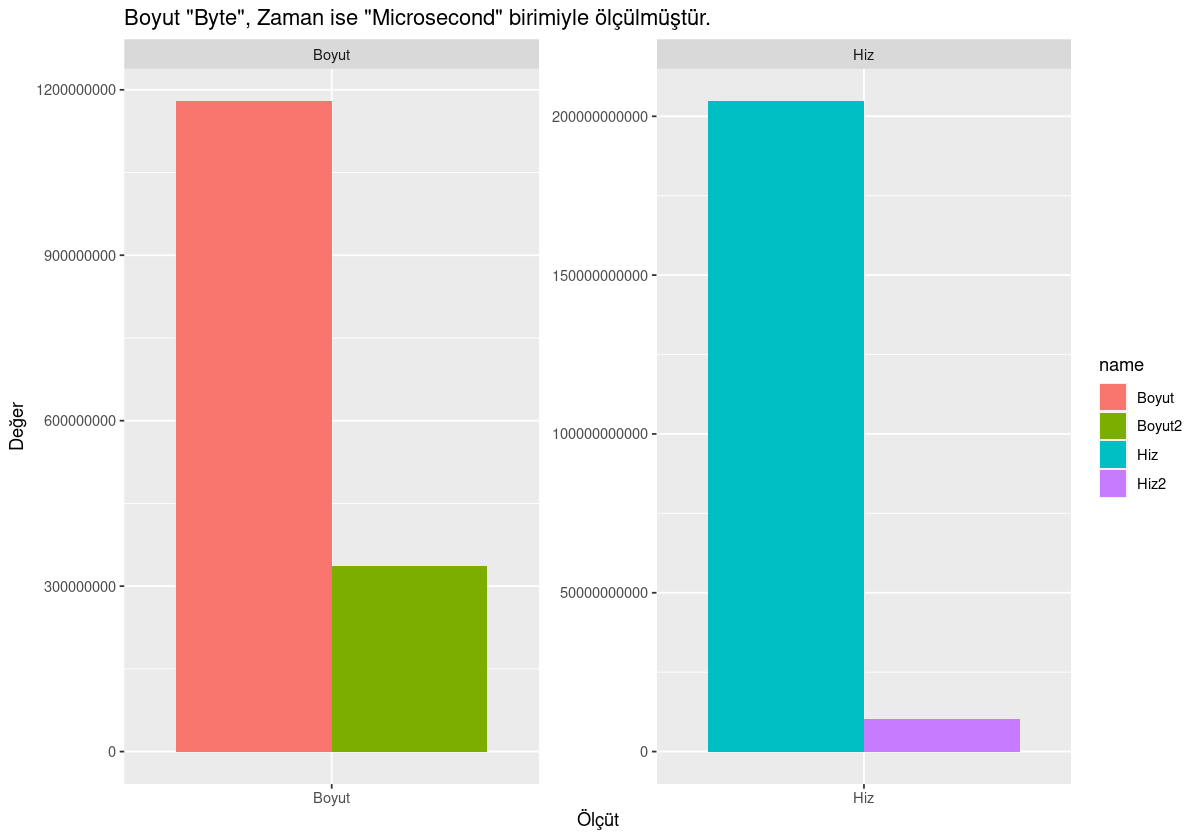

In [28]:
options(scipen=999)
options(repr.plot.width=10)
file_infos %>% 
select(-Dosya) %>% 
summarise_all(sum) %>% 
pivot_longer(cols = everything()) %>% 
mutate(type=gsub('2','',name)) %>% 
ggplot(aes(x=type,y=value,fill=name))+
geom_bar(stat='identity',position = 'dodge') + 
facet_wrap(~type,scales = 'free')+
xlab('Ölçüt')+ylab('Değer')+
ggtitle('Boyut "Byte", Zaman ise "Microsecond" birimiyle ölçülmüştür.')

In [29]:
file_infos

Dosya,Boyut,Boyut2,Hiz,Hiz2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
economic_calendar.csv,2196012,1350477,153067963,22863115
economic_variables.csv,43571,35492,5855328,463331
live_digital_campaigns.csv,6255,1374,1450404,394514
transactions.csv,1176731744,335690392,204530926360,10380422008
